### EL5206-1: Laboratorio de Inteligencia Computacional y Robótica
## Laboratorio 1: Procesamiento de Imágenes

Integrantes:

*   Leslie Cárdenas
*   Matías Guzmán

# Introducción

Este laboratorio tiene como objetivo familiarizarse con el manejo de imágenes en Python y algunas operaciones básicas en 2D, mediante el desarrollo de actividades tales como binarización de imágenes, segmentación, aumento de contraste y transformaciones de fourier en 2D.

A lo largo de este reporte, se desarrollan las tareas propuestas en el orden dado y se infiere información a partir de cada experiencia. Finalmente, se presentan las conclusiones más importantes.

# Desarrollo

Se decide utilizar Python en GoogleColab para implementar este laboratorio. Para partir, es necesario instalar e importar librerías a utilizar, entre las que se encuentran `numpy`, `spicy` y `matplotlib`.

In [ ]:
!pip install imhist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2 as cv2
from google.colab.patches import cv2_imshow
from imhist import imhist, imcdf
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

## Parte 1
**Instrucción:** Cargue la imagen ‘tomates.png’ con 'imread' y despliegue su contenido con 'imshow' o 'imagesc'.
Convierta la imagen a escala de grises y visualice su histograma. Utilizando un umbral t, obtenga una
imagen binaria (pruebe al menos tres valores para t). Muestre y comente los resultados. Suponga que
ahora solo se desea segmentar el tomate de color rojo. Analice si es posible utilizando solamente uno de
los tres canales de la imagen RGB obteniendo una imagen binaria o si debe utilizar operaciones básicas
entre dos canales

Se parte por importar, llevar a escala de grises y sacar el histograma de la imagen "tomates".

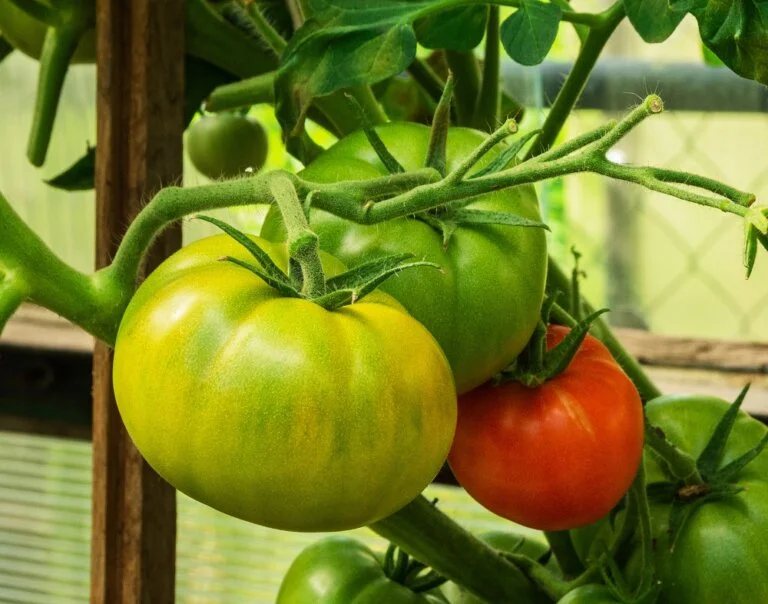

In [ ]:
tomates = cv2.imread("tomates.png")
cv2_imshow(tomates)

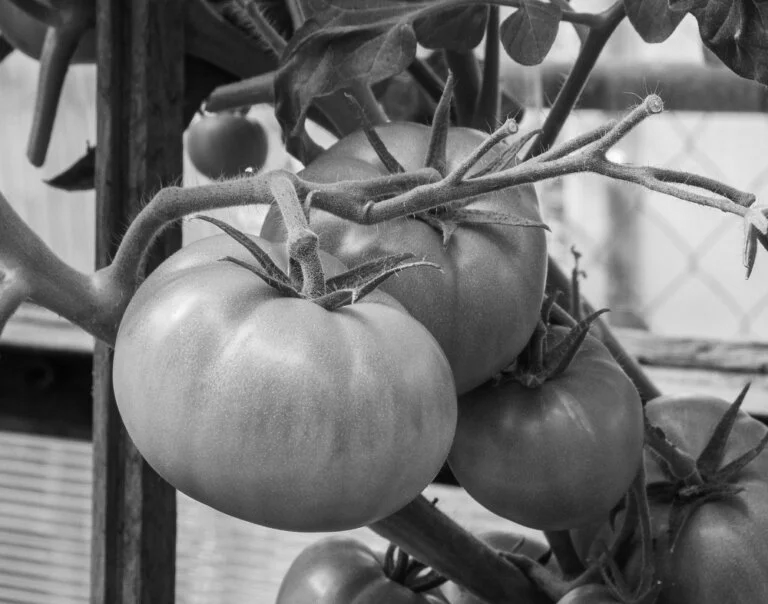

In [ ]:
tomate_gris = cv2.cvtColor(tomates, cv2.COLOR_BGR2GRAY)
cv2_imshow(tomate_gris)

Text(0.5, 0, 'Nivel de gris')

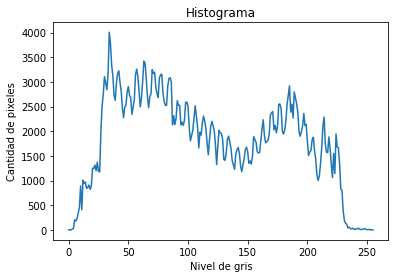

In [ ]:
hist = cv2.calcHist([tomate_gris], [0], None, [256], [0,256])
plt.plot(hist)
plt.title("Histograma")
plt.ylabel("Cantidad de pixeles")
plt.xlabel("Nivel de gris")

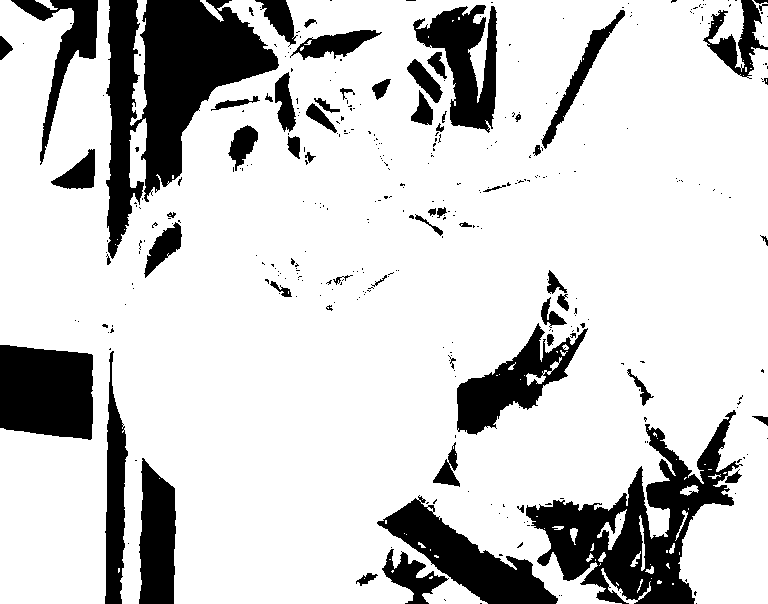

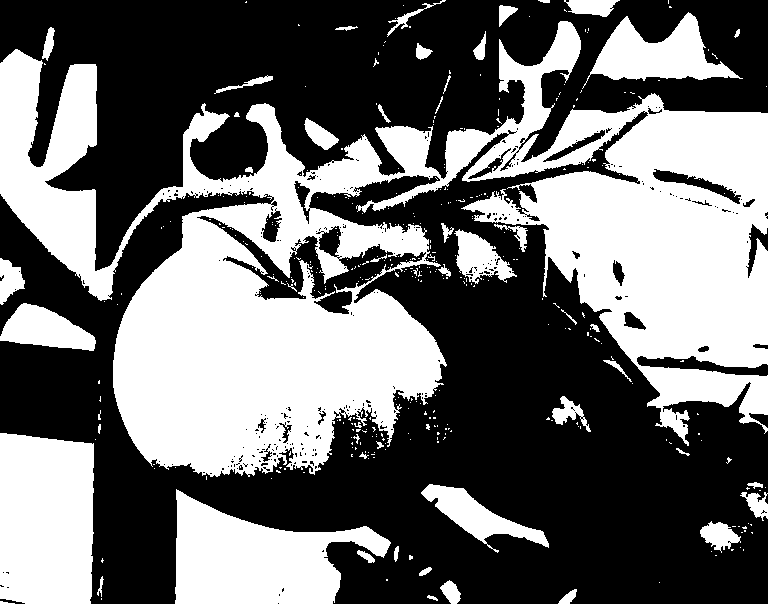

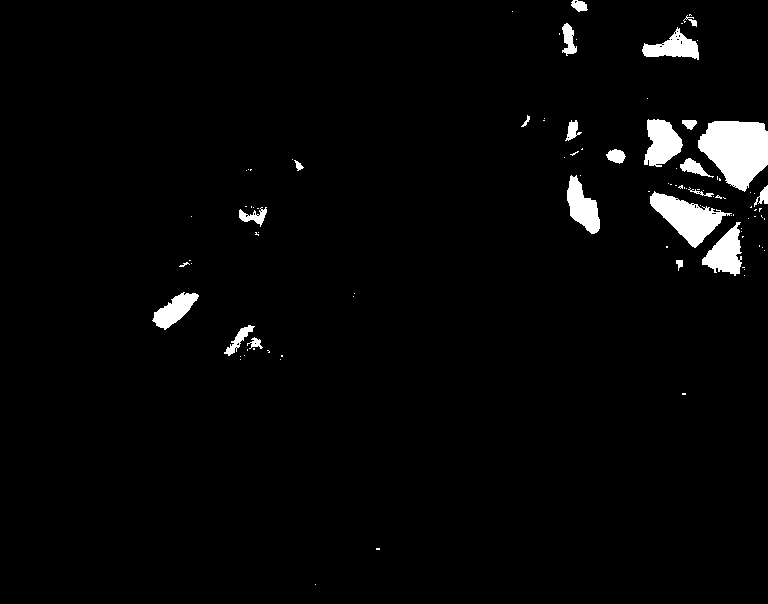

In [ ]:
# Aplicamos la función threshold con la condición THRESH_BINARY: Los pixeles que cumplan la condicion se van a 255
_, bin1 = cv2.threshold(tomate_gris, 50, 255, cv2.THRESH_BINARY)
_, bin2 = cv2.threshold(tomate_gris, 120, 255, cv2.THRESH_BINARY)
_, bin3 = cv2.threshold(tomate_gris, 220, 255, cv2.THRESH_BINARY)

cv2_imshow(bin1)
cv2_imshow(bin2)
cv2_imshow(bin3)

En las imágenes binarias, se puede notar que a medida en que aumentamos el umbral, la imágen se vuelve cada vez más oscura. Esto ocurre ya que cada vez **menos** pixeles cumplen la condición, lo que se puede confirmar mirando el histograma. De la misma forma, cuando $t = 50$, la imágen es mayoritariamente blanca.

Para segmentar exclusivamente el tomate rojo, se realiza lo siguiente: Primero, visualizemos los canales por separado.

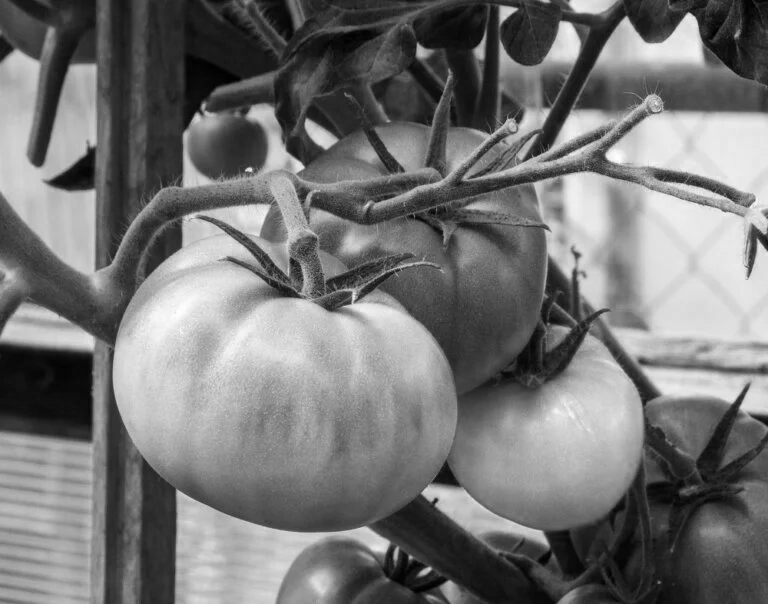

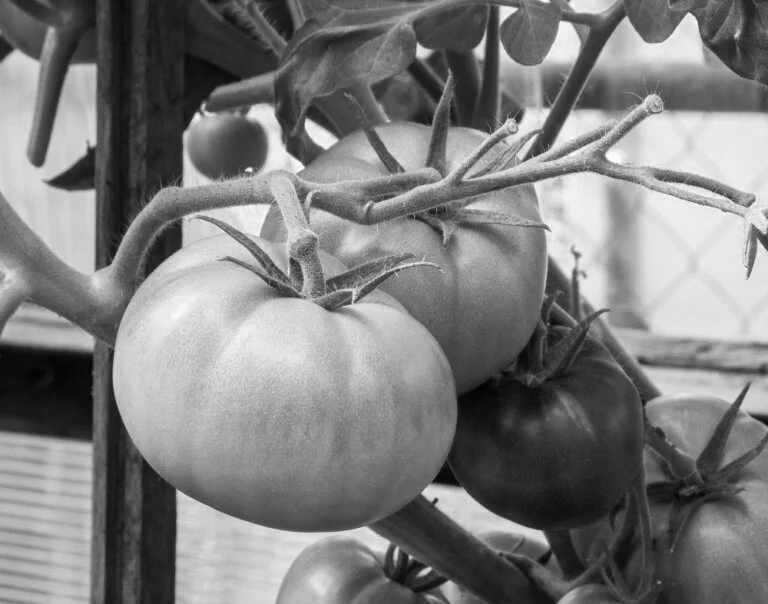

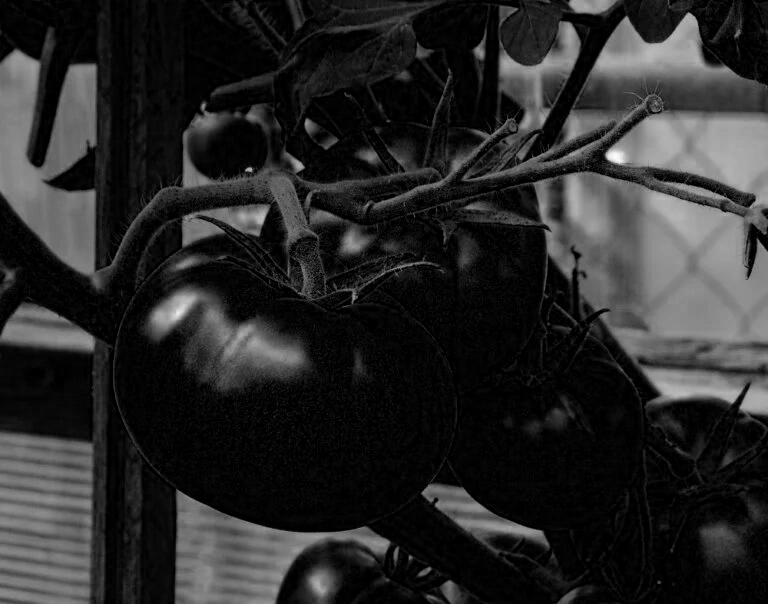

In [ ]:
R = tomates[:,:,2]
cv2_imshow(R)

G = tomates[:,:,1]
cv2_imshow(G)

B = tomates[:,:,0]
cv2_imshow(B)

Se puede notar que en los canales R (rojo) y G (verde) los tomates que **no** son rojos, tienen valores similares, mientras que el tomate rojo tiene alto valor en el canal rojo y bajo valor en el canal verde. Por otra parte, el canal azul tiene muy pocos valores en todos lados.

Teniendo en cuenta esto, se puede realizar la sustracción ROJO menos VERDE menos AZUL para obtener exclusivamente el tomate rojo.

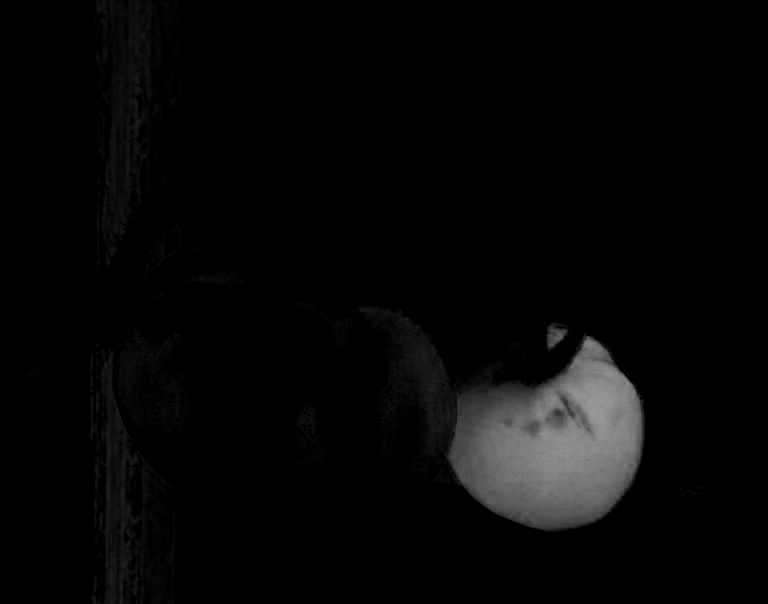

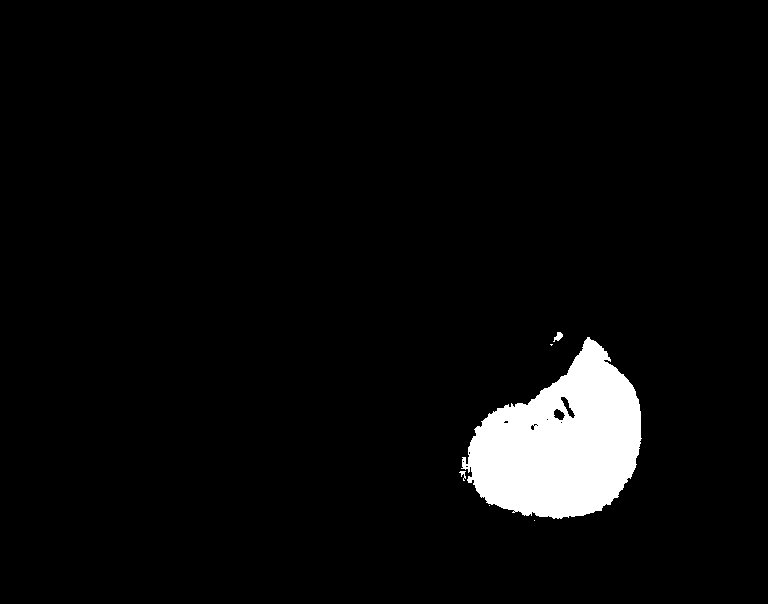

In [ ]:
R = tomates[:,:,2]
B = tomates[:,:,0]
G = tomates[:,:,1]

RsinG = cv2.subtract(R, G)
RsinGsinB = cv2.subtract(RsinG, B)

cv2_imshow(RsinGsinB)

# Ahora lo hacemos binario

_, segmentado = cv2.threshold(RsinGsinB, 80, 255, cv2.THRESH_BINARY)

cv2_imshow(segmentado)

No es posible lograr esta segmentación **SOLO** con el canal rojo, ya que los otros tomates verdes, aunque no se note a simple vista, también tienen valores no despreciables en este canal (no son puramente verdes).

# Parte 2

**Instrucción:** Usando la función ‘imhist’ visualice el histograma de las imágenes ‘moon.png’, ‘old.png’ y ‘pool.png’.
Diseñe una transformación mediante un estiramiento lineal de contraste que mejore el contraste en las
imágenes. Indique la transformación (ecuación) y aplíquela a la imagen original. Muestre tanto la imagen
original como la transformada, con sus respectivos histogramas, para cada caso.

Primero se crea la función `contrastStre` que es capaz de aplicar el estiramiento de constraste a un canal según parametros variables para cada caso. La función de estiramiento es una definida por partes, tal como se ve en la imagen siguiente. Se puede describir como sigue, considerando a $x$ como el valor original del pixel, $y$ como el nuevo valor, $a$ (punto rojo) y $b$ (punto azul) como parámetros a definir:
* Para $x< a$, $y=0$ (segmento rojo).
* Para $a< x< b$, $y=\frac{255}{b-a}x+\frac{-255}{b-a}a$, lo que a grandes rasgos define una recta creciente desde 0 a 255 para valores entre $a$ y $b$ (segmento verde).
* Para $b< x$, $y=255$ (segmento azul).

![image_2023-03-16_141715282.png](https://drive.google.com/uc?export=view&id=1-akU9llS_3jqrByZjU8ss2OKcazuv2h1)

In [ ]:
def contrastStre(ch, a, b):
    for i in range(ch.shape[0]):
        for j in range(ch.shape[1]):
            if ch[i,j]<a:
                ch[i,j]=0
            elif ch[i,j]>b:
                ch[i,j]=255
            else:
                ch[i,j]=255/(b-a)*ch[i,j]+(-255/(b-a)*a)
    return ch

Luego, se procede a aplicar tal transformación sobre las imágenes entregadas y mostrar el histograma correspondiente a cada caso.

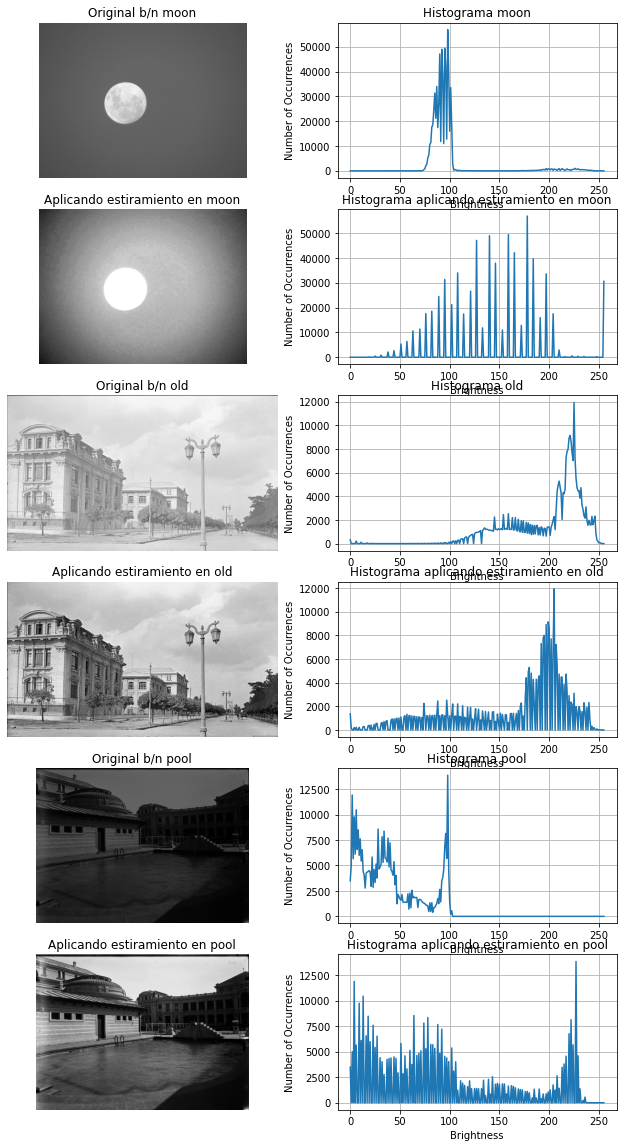

In [ ]:
# Se crea una figura para mostrar las 3 imágenes en sus 2 versiones y correspondientes histogramas.
fig , axs = plt.subplots(6, 2, figsize =(11, 20))

# Se cargan las imágenes en blanco y negro, siguiendo las instrucciones dadas por el equipo docente.
moon = cv2.imread("moon.png", cv2.IMREAD_GRAYSCALE)
old = cv2.imread("old.png", cv2.IMREAD_GRAYSCALE)
pool = cv2.imread("pool.png", cv2.IMREAD_GRAYSCALE)

imgs = [moon, old, pool]
n_imgs = ["moon", "old", "pool"]

# Para cada imagen original se genera un histograma. 
for i in range(len(imgs)):
    # Mostrar imagen original
    axs[i*2, 0].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    title= "Original b/n "+n_imgs[i]
    axs[i*2, 0].set_title(title)
    axs[i*2, 0].axis('off')

    # Mostrar histograma original.
    hist = imhist(imgs[i])

    title = "Histograma " + n_imgs[i]
    axs[i*2, 1].plot(np.arange(256), hist)
    axs[i*2, 1].set_title(title)
    axs[i*2, 1].set_ylabel('Number of Occurrences')
    axs[i*2, 1].set_xlabel('Brightness')
    axs[i*2, 1].grid(which="both")

# Tras observar los histogramas oringinales se determina el rango para cada imagen.
a = [70, 100, 0]
b = [110, 255, 110]

for i in range(len(imgs)):
    # Se aplica el estiramiento de constraste considerando los parámetros anteriores.
    img_str = contrastStre(imgs[i], a[i], b[i])

    # Mostrar imagen con estiramiento aplicado
    axs[i*2+1, 0].imshow(cv2.cvtColor(img_str, cv2.COLOR_BGR2RGB))
    title= "Aplicando estiramiento en "+n_imgs[i]
    axs[i*2+1, 0].set_title(title)
    axs[i*2+1, 0].axis('off')

    # Mostrar histograma de imagen con estiramiento aplicado
    hist = imhist(img_str)
    title = "Histograma aplicando estiramiento en "+n_imgs[i]
    axs[i*2+1, 1].plot(np.arange(256), hist)
    axs[i*2+1, 1].set_title(title)
    axs[i*2+1, 1].set_ylabel('Number of Occurrences')
    axs[i*2+1, 1].set_xlabel('Brightness')
    axs[i*2+1, 1].grid(which="both")

plt.show()

Notar que la decisión de los parámetros $a$ y $b$ se realiza observando los histogramas de las imágenes originales y seleccionando el rango de valores donde se encuentran la mayor cantidad de píxeles. En el caso de la imagen "moon" del histograma de desprende que la luminosidad es bastante pareja y media (no blanco, ni negro), lo que se adecua a lo esperado. Así mismo, la segunda y tercera imagen están respectivamente desviadas hacia una luminosidad alta y baja.

Luego de aplicar el estiramiento de contraste se obtienen imágenes mucho más equilibradas en luminosidad. En la primera se ven detalles que pasaban desapercibidos anteriormente, pero a su vez se pierde detalle en la luna como tal. Esto dependiendo de la utilidad que se le quiera dar a la imágen podría no ser beneficioso. En cuanto a las últimas dos, se observa una clara mejora: los bordes o delimitaciones de las partes de la imagen son mucho más evidentes.

Es importante destacar que, tanto la selección de parámetros, como la de la función, dependen meramente de una decisión humana, por lo que el resultado podría variar ligeramente. Aún así, este debería generar el mismo efecto si se aplica de buena forma.

# Parte 3
**Instrucción:** Calcule la Transformada de Fourier en 2D (en escala de grises) de la imagen ‘fence.png’ usando el método
‘fft2’. Visualice su magnitud y comente lo que observa. Para corregir la visualización calcule la
transformación logarítmica de la transformada de Fourier descrita en la ecuación. ¿Por qué se produce el
cambio en la forma en que se visualiza la transformada? Aplique los pasos anteriores sobre la imagen
‘diagonal.png’ y analice su transformada de Fourier. 

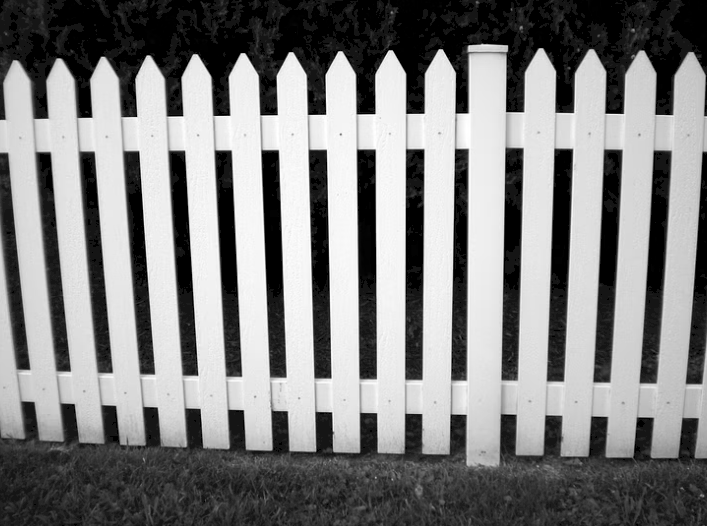

In [ ]:
fence = cv2.imread("fence.png", cv2.IMREAD_GRAYSCALE)
cv2_imshow(fence)

Primero, ocupamos la función `fft2` del paquete `numpy`. Esta función nos entrega la Transformada de Fourier en 2D, compuesta por números complejos


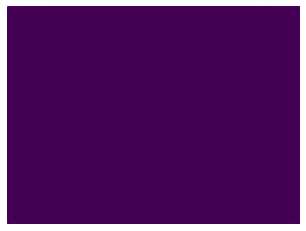

In [ ]:
# FFT entrega numero complejo
fenceFFT = np.fft.fft2(fence)
plt.axis("off")
plt.imshow(abs(fenceFFT))
#print(abs(fenceFFT))

En lo anterior, se puede notar que, al calcular y graficar las magnitudes de los componentes de la variable `fenceFFT`, no se puede distingir nada importante, pues se ve constante en todo el espectro.

Ahora, si se muestran los valores que toma la FFT (siguiente gráfico), se puede notar que se tienen frecuencias muy altas y muy bajas, lo que al llevarlo a una función que asigna linealmente los colores (como lo es `imshow` y todas las similares), no permite visualizar una diferencia entre los mismos valores altos.

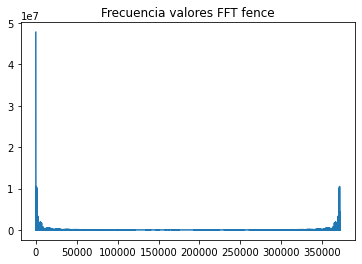

In [ ]:
newshape = np.reshape(abs(fenceFFT), (1,-1))
plt.title("Frecuencia valores FFT fence")
plt.plot(newshape[0])

Siguiendo, se implementa la transformación logarítimica que llamamos `G(i,j,P,R)`.

In [ ]:
def G(i,j,P,R):
  c = 255/(np.log(1+abs(R)))
  return c*np.log(1+abs(P))

R = np.max(abs(fenceFFT)) # Magnitud máxima de la FFT

# Se cambian todos los valores
for i in range(fenceFFT.shape[0]):
  for j in range(fenceFFT.shape[1]):
    fenceFFT[i,j] = G(i,j,fenceFFT[i,j], R)
fenceFFT = fenceFFT.astype("uint8")

<ipython-input-14-2f9d8121e013>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  fenceFFT = fenceFFT.astype("uint8")


Una vez transformados, le hacemos shift para graficar correctamente:

[[255 208 196 ... 180 196 208]
 [233 187 180 ... 185 188 195]
 [232 176 161 ... 162 167 187]
 ...
 [213 185 169 ... 178 170 191]
 [232 187 167 ... 175 161 176]
 [233 195 188 ... 167 180 187]]


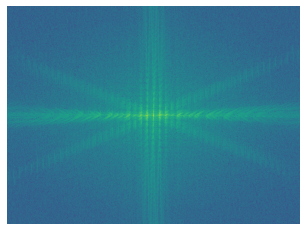

In [ ]:
plt.axis("off")
plt.imshow(np.fft.fftshift(fenceFFT))
print(fenceFFT)

Ahora, se repite el procedimiento con la imagen "diagonal".




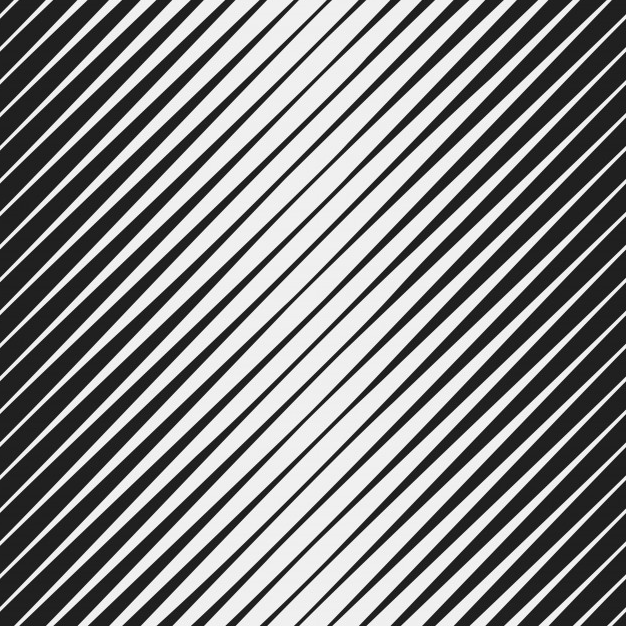

In [ ]:
diagonal = cv2.imread("diagonal.jpg", cv2.IMREAD_GRAYSCALE)
cv2_imshow(diagonal)

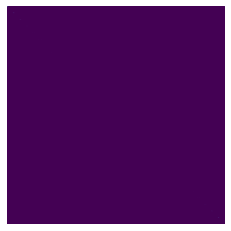

In [ ]:
# FFT entrega numero complejo
plt.axis("off")
diagFFT = np.fft.fft2(diagonal)
plt.imshow(abs(diagFFT))

Nuevamente, el gráfico no entrega información.

In [ ]:
def G(i,j,P,R):
  c = 255/(np.log(1+abs(R)))
  return c*np.log(1+abs(P))

# Encontramos el valor más grande
R = np.max(abs(diagFFT))
for i in range(diagFFT.shape[0]):
  for j in range(diagFFT.shape[1]):
    diagFFT[i,j] = G(i,j,diagFFT[i,j], R)
diagFFT = diagFFT.astype("uint8")

<ipython-input-18-22a445f1740c>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  diagFFT = diagFFT.astype("uint8")


Una vez transformados, le hacemos shift y lo graficamos

(-0.5, 625.5, 625.5, -0.5)

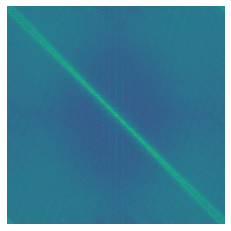

In [ ]:
plt.imshow(np.fft.fftshift(diagFFT))
plt.axis("off")

En la FFT anterior se observa una recta con pendiente. Así, en primer lugar, se tiene que el espectro de Fourier esta rotado tal como la imagen. Si la imagen original estuviera horizontal ( o vertical) el espectro también deberia estarlo. 

También contrasta con la teoría, ya que la transformada de Fourier en 2D de una sinusoide espacial, es una delta de dirac perfecta. Como la imagen diagonal está en blanco y negro alternado, se está muy cerca de este caso ideal, sin embargo no es perfecto y es por esto que tenemos una recta compuesta por muchos puntos, lo que se corresponde a todos los senos y cosenos de una sumatoria de Fourier.

La imagen `fence` tiene un espectro similar al de la segunda imagen, pero con un poco más de ruido. Esto puede deberse a que ambas muestran patrones periódicos de colores blanco y negro.

# Parte 4
**Instrucción:** Usando la misma estrategia de la transformación logarítmica, compare el espectro de frecuencia (‘fft2’ y ‘fftshift’) de la imagen ‘space.png’ y su rotación en 45° y 60° (utilice el método ‘imrotate’). Comente los
resultados.

Se cargan y rotan las imágenes, ocupando método `rotate` de la librería `scipy`.

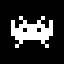

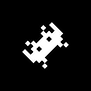

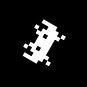

In [ ]:
space = cv2.imread("space.png", cv2.IMREAD_GRAYSCALE)
space45 = ndimage.rotate(space, 45)
space60 = ndimage.rotate(space, 60)

cv2_imshow(space)
cv2_imshow(space45)
cv2_imshow(space60)

In [ ]:
spaceFFT = np.fft.fft2(space)
spaceFFT45 = np.fft.fft2(space45)
spaceFFT60 = np.fft.fft2(space60)

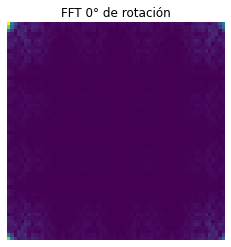

In [ ]:
plt.axis("off")
plt.title("FFT 0° de rotación")
plt.imshow(abs(spaceFFT))

(-0.5, 90.5, 90.5, -0.5)

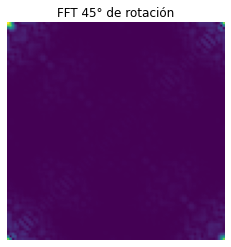

In [ ]:
plt.imshow(abs(spaceFFT45))
plt.title("FFT 45° de rotación")
plt.axis("off")

(-0.5, 86.5, 86.5, -0.5)

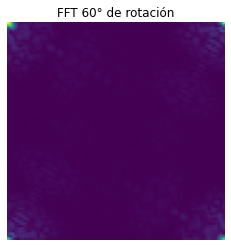

In [ ]:
plt.imshow(abs(spaceFFT60))
plt.title("FFT 60° de rotación")
plt.axis("off")

De forma general, con las FFT obtenidas es díficil sacar conclusiones. Sin embargo, se logra notar en las rotaciones de 45° y 60° unas líneas con sus inclinaciones respectivas que apuntan al centro.

Pasando a las transformaciones logarítmicas de las FTT anteriores, se tiene lo siguiente.

In [ ]:
spaces = [spaceFFT, spaceFFT45, spaceFFT60]
angs = [0, 45, 60]

<ipython-input-60-a9b60b6db040>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  fft = fft.astype("uint8")


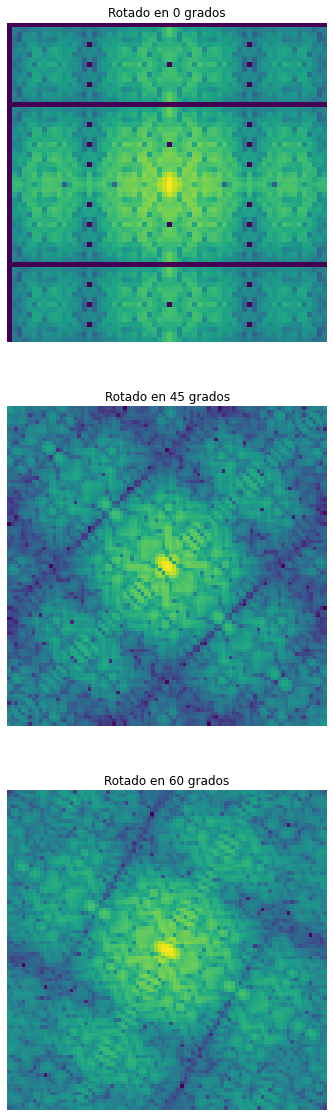

In [ ]:
fig , axs = plt.subplots(3, 1, figsize =(11, 20))

for k, fft in enumerate(spaces):
  R = np.max(abs(fft))
  for i in range(fft.shape[0]):
    for j in range(fft.shape[1]):
      fft[i,j] = G(i,j,fft[i,j], R)
  fft = fft.astype("uint8")
  axs[k].imshow(np.fft.fftshift(fft))
  axs[k].axis("off")
  titulo = f"Rotado en {angs[k]} grados"
  axs[k].set_title(titulo)
plt.show()

Se observa que al rotar las imágenes originales en el espacio, los espectros de frecuencia también lo hacen en el mismo ángulo y sentido, lo que tiene sentido con la definición de la transformada en 2D. También se notan ciertas diferencias en la tonalidad de los colores, pero esto se puede asignar a que el tamaño de las imágenes cambia al rotarlas y se rellenan con negro.

#Conclusión

Dado lo realizado se concluye que los objetivos planteados se cumplen debidamente, pues se pudo conocer una gama de métodos y funciones útiles para la manipulación de imágenes. Además, se destaca el entendimiento sobre los componentes de cada canal en las imágenes RGB. En esta línea, se determina que en la vida real lo que detectan nuestros ojos (y de forma similar, las cámaras) siempre son una mezcla de colores: rojo, verde y azul. Así mismo se tiene que los colores puros son prácticamente imposibles de visualizar.

Por otra parte, en la segunda parte se aprendió una de las tantas herramientas que se tienen para mejorar el contraste de una imagen, el estiramiento lineal de contraste. Esto se considera que es elemental a la hora de, por ejemplo, detectar bordes, objetos u personas en imágenes que a simple vista parecían no ser ideales para esa tarea. Sin embargo, es importante notar que realizar esta selección manual de parámetros con miles o millones de imágenes, claramente no es realista, por lo que existen otras herramientas más automáticas capaces de hacer tal modificación.

En la tercera parte se logra hacer un paralelismo entre la teoría y la práctica, en donde vemos reflejado el espectro de fourier de una imagen blanco y negro simple `diagonal` y una imagen blanco y negro algo más compuesta, como lo es `fence`. Ambas poseen un espectro de frecuencia similar, aunque con sus debidas diferencias.

También, se rescata el aprendizaje sobre la importancia que tienen las transformaciones lineales, como la rotación, en el espectro de frecuencia 2D de la misma.